In [ ]:
!pip uninstall tensorflow 
!pip install tensorflow==2.7.0

In [ ]:
import numpy as np
import pandas as pd
import random
import os 

from tensorflow import keras
from tensorflow.keras import datasets, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, BatchNormalization, Activation, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.utils import to_categorical

from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import classification_report
from tensorflow.keras.optimizers import Adam
import plotly.graph_objects as go 

from sklearn.metrics import confusion_matrix
from sklearn.datasets import load_iris # 샘플 데이터 로딩
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots

from glob import glob
from PIL import Image

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!pip install kaggle
from google.colab import files
files.upload()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"dmswl688","key":"355133a54cd203ae99d05e431a81c30c"}'}

In [ ]:
ls -1ha kaggle.json

kaggle.json


In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
# Permission Warning이 발생하지 않도록
! kaggle datasets download -d kmader/skin-cancer-mnist-ham10000

100% 5.20G/5.20G [03:56<00:00, 24.0MB/s]
100% 5.20G/5.20G [03:56<00:00, 23.6MB/s]


In [ ]:
!ls

gdrive	kaggle.json  sample_data  skin-cancer-mnist-ham10000.zip


In [ ]:
!unzip skin-cancer-mnist-ham10000.zip

ㅇㅇㅇㅇㅇㅇㅇㅇㅇㅇㅇㅇㅇㅇㅇㅇㅇㅇㅇㅇㅇㅇㅇㅇㅇㅇㅇㅇ

In [ ]:
df = pd.read_csv('./hmnist_28_28_RGB.csv')
df.head()
#10015rows x 2353 columns

,pixel0000,pixel0001,pixel0002,pixel0003,pixel0004,pixel0005,pixel0006,pixel0007,pixel0008,pixel0009,...,pixel2343,pixel2344,pixel2345,pixel2346,pixel2347,pixel2348,pixel2349,pixel2350,pixel2351,label
0,192,153,193,195,155,192,197,154,185,202,...,173,124,138,183,147,166,185,154,177,2
1,25,14,30,68,48,75,123,93,126,158,...,60,39,55,25,14,28,25,14,27,2
2,192,138,153,200,145,163,201,142,160,206,...,167,129,143,159,124,142,136,104,117,2
3,38,19,30,95,59,72,143,103,119,171,...,44,26,36,25,12,17,25,12,15,2
4,158,113,139,194,144,174,215,162,191,225,...,209,166,185,172,135,149,109,78,92,2


In [ ]:
label = df["label"]
df = df.drop(columns=["label"]) 

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


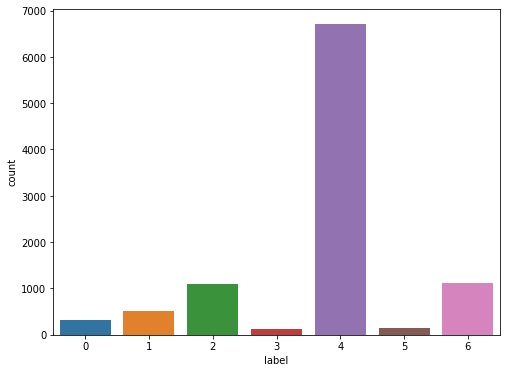

In [ ]:
import seaborn as sns

plt.figure(figsize = (8,6))
sns.countplot(label)

In [ ]:
x_train , x_test , y_train , y_test = train_test_split(df , label , test_size = 0.02)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


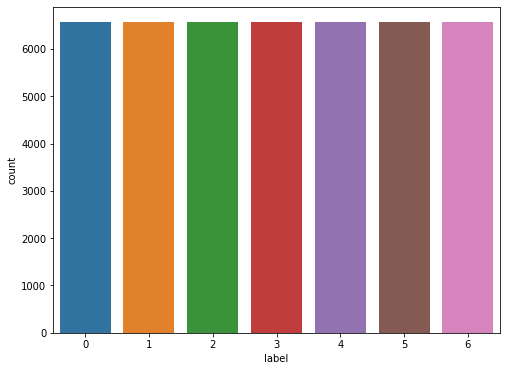

In [ ]:
from imblearn.over_sampling import RandomOverSampler as ROS 

sampler = ROS()
x_train, y_train = sampler.fit_resample(x_train, y_train)

plt.figure(figsize = (8,6))
sns.countplot(y_train)

In [ ]:
x_train = np.array(x_train).reshape(-1,28,28,3)
x_test = np.array(x_test).reshape(-1,28,28,3)

In [ ]:
x_train = x_train.astype('float32')
x_train = x_train/255
x_test = x_test.astype('float32')
x_test = x_test/255

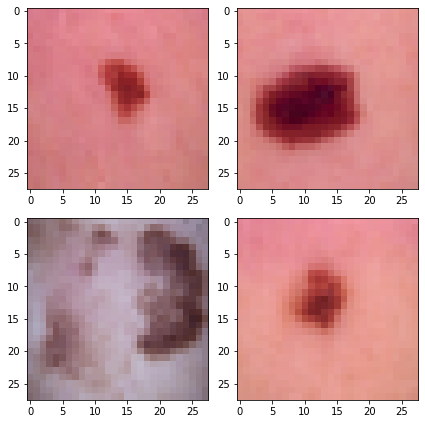

In [ ]:
fig, axes = plt.subplots(2, 2)
fig.set_size_inches(6, 6)
k = 0 
for i in range(2):
    for j in range(2):
        axes[i, j].imshow(x_train[k])
        k += 1
plt.tight_layout()

In [ ]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255, #0~1사이로 픽셀값 변환
                                  rotation_range = 10,
                                  width_shift_range = 0.2,
                                  height_shift_range = 0.2,
                                  shear_range = 0.2,
                                  horizontal_flip = True,
                                  vertical_flip = True,
                                  fill_mode = 'nearest')
train_datagen.fit(x_train)
test_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen.fit(x_test)

In [ ]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
#데이터 포맷 확인
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(45948, 28, 28, 3)
(45948, 7)
(201, 28, 28, 3)
(201, 7)


In [ ]:
#모델 구축
model = Sequential()
model.add(Conv2D(32, kernel_size = (3,3), input_shape = (28, 28, 3), activation = 'relu', padding = 'same'))
model.add(MaxPooling2D(pool_size = (2,2)))

BatchNormalization()
model.add(Conv2D(64, kernel_size = (3,3), activation = 'relu', padding = 'same'))
model.add(Conv2D(64, kernel_size = (3,3), activation = 'relu', padding = 'same'))
model.add(MaxPooling2D(pool_size = (2,2), padding = 'same'))

BatchNormalization()
model.add(Conv2D(128, kernel_size = (3,3), activation = 'relu', padding = 'same'))
model.add(Conv2D(128, kernel_size = (3,3), activation = 'relu', padding = 'same'))
model.add(MaxPooling2D(pool_size = (2,2), padding = 'same'))

BatchNormalization()
model.add(Conv2D(256, kernel_size = (3,3), activation = 'relu', padding = 'same'))
model.add(Conv2D(256, kernel_size = (3,3), activation = 'relu', padding = 'same'))
model.add(MaxPooling2D(pool_size = (2,2), padding = 'same'))

model.add(Flatten())
model.add(Dense(64, activation = 'relu'))
model.add(Dense(32, activation='relu'))
Dropout(0.5)
model.add(Dense(7, activation='softmax'))

optimizer = Adam(learning_rate = 0.001)

In [ ]:
model.compile(loss='categorical_crossentropy',optimizer="adam",metrics=[f1_m, 'accuracy'])

In [ ]:
#make model folder model
model._name = 'skincancer_CNN'
model_save_path = "."
if not os.path.exists(model_save_path):
    os.mkdir(model_save_path)

In [ ]:
early_stop = EarlyStopping(patience=10, verbose=1, monitor='val_f1_m', mode='max')
reduce_lr =  ReduceLROnPlateau(monitor='val_f1_m', factor=0.1, patience=7, min_delta=1e-4, mode='max')
checkpoint = ModelCheckpoint(os.path.join(model_save_path, model.name+".h5"), save_weights_only=True,
                             verbose=1, save_best_only=True, monitor='val_f1_m', mode='max')

In [ ]:
model.summary()

Model: "skincancer_CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_11 (Conv2D)          (None, 28, 28, 32)        896       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 conv2d_12 (Conv2D)          (None, 14, 14, 64)        18496     
                                                                 
 conv2d_13 (Conv2D)          (None, 14, 14, 64)        36928     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                             
                                                                 
 conv2d_14 (Conv2D)          (None, 7, 7, 128)      

In [ ]:
history = model.fit(x_train,
                    y_train,
                    epochs=25,
                    batch_size=90,
                    #steps_per_epoch=len(x_train)//128,
                    validation_data= (x_test, y_test),
                    callbacks=[early_stop, checkpoint, reduce_lr])

Epoch 1/25
509/511 [============================>.] - ETA: 0s - loss: 1.3820e-06 - f1_m: 1.0000 - accuracy: 1.0000
Epoch 1: val_f1_m improved from 0.84464 to 0.84497, saving model to ./skincancer_CNN.h5
511/511 [==============================] - 5s 10ms/step - loss: 1.3814e-06 - f1_m: 1.0000 - accuracy: 1.0000 - val_loss: 2.4477 - val_f1_m: 0.8450 - val_accuracy: 0.8408 - lr: 1.0000e-05
Epoch 2/25
510/511 [============================>.] - ETA: 0s - loss: 1.2916e-06 - f1_m: 1.0000 - accuracy: 1.0000
Epoch 2: val_f1_m improved from 0.84497 to 0.84868, saving model to ./skincancer_CNN.h5
511/511 [==============================] - 5s 9ms/step - loss: 1.2930e-06 - f1_m: 1.0000 - accuracy: 1.0000 - val_loss: 2.4588 - val_f1_m: 0.8487 - val_accuracy: 0.8458 - lr: 1.0000e-05
Epoch 3/25
509/511 [============================>.] - ETA: 0s - loss: 1.1899e-06 - f1_m: 1.0000 - accuracy: 1.0000
Epoch 3: val_f1_m did not improve from 0.84868
511/511 [==============================] - 5s 9ms/step - lo

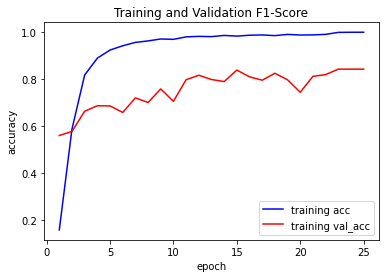

In [ ]:
f1 = history.history["f1_m"]
val_f1 = history.history["val_f1_m"]
epochs = range(1, len(val_f1) + 1)

plt.plot(epochs, f1, color="blue", label="training acc")
plt.plot(epochs, val_f1, color="red", label="training val_acc")
plt.legend()
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.title("Training and Validation F1-Score")
# plt.savefig(f"./balanced/models/{model._name}_f1_training_plot.jpg")
plt.show()

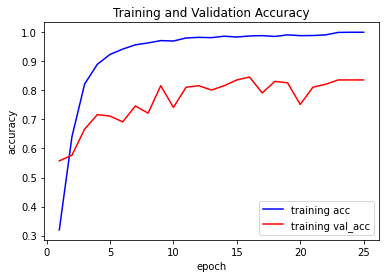

In [ ]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
epochs = range(1, len(val_acc) + 1)

plt.plot(epochs, acc, color="blue", label="training acc")
plt.plot(epochs, val_acc, color="red", label="training val_acc")
plt.legend()
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.title("Training and Validation Accuracy")
# plt.savefig(f"./balanced/models/{model._name}_f1_training_plot.jpg")
plt.show()

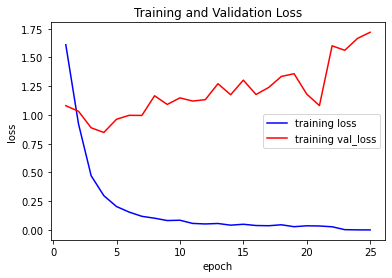

In [ ]:
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(val_acc) + 1)

plt.plot(epochs, loss, color="blue", label="training loss")
plt.plot(epochs, val_loss, color="red", label="training val_loss")

plt.legend()
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("Training and Validation Loss")

plt.show()